In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim

In [7]:
# transform 정의 : Resize 후 Tensor 형태로
transform = transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.RandomResizedCrop(244),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
                              
                              

In [ ]:
  

train_path = r".\cat_dog_classification\catanddog\train"
test_path = r".\cat_dog_classification\catanddog\test"

train_dataset = ImageFolder(train_path, transform)
train_dataset = ImageFolder(test_path, transform)

train_dataloader = DataLoader(dataset = train_dataset, batch_size=32, shuffle=True, num_workers= 3)
test_dataloader = DataLoader(dataset = train_dataset, batch_size=32, shuffle=True, num_workers= 3)

IndexError: index 12 is out of bounds for axis 0 with size 12

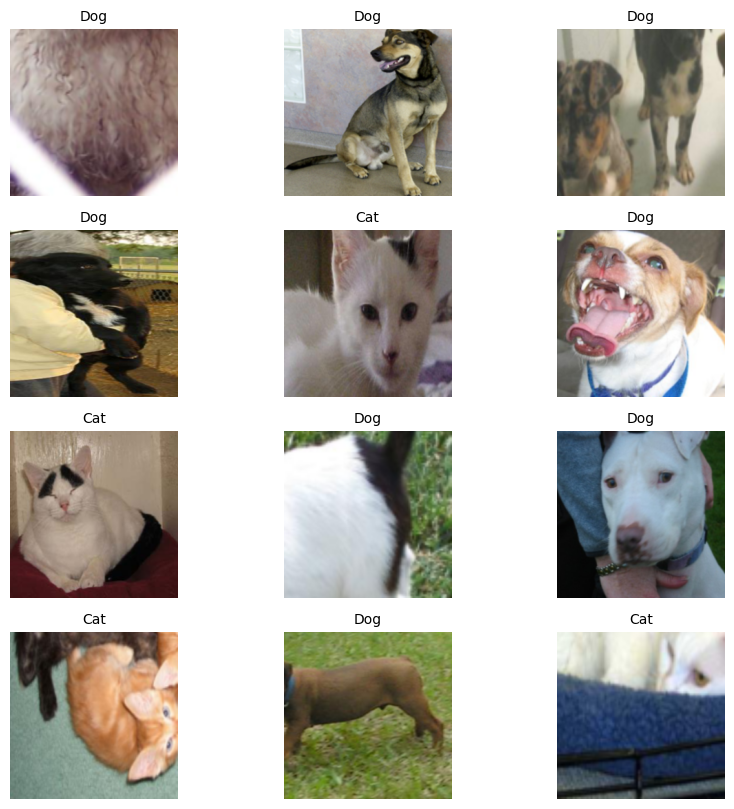

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# train_features와 train_labels 가져오기
train_features, train_labels = next(iter(train_dataloader))


label = {v : k for k, v in train_dataset.class_to_idx.items()}

# 4x3 그리드 생성
fig, axes = plt.subplots(4, 3, figsize=(10, 10))  # figsize로 크기 조정
axes = axes.flatten()  # 2D 배열을 1D로 변환

for i in range(len(train_features)):
    # train_features[i]는 Tensor 형태이므로 numpy로 변환 필요
    img = train_features[i]
    
    # 채널 순서를 (C, H, W) -> (H, W, C)로 변환
    img = np.transpose(img, (1, 2, 0))

    # 그래프 축 선택
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"{label[train_labels[i].item()]}", fontsize=10)
    ax.axis('off')  # 축 제거

In [ ]:
class cat_dog_cnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.covn = nn.Sequential(
                                # conv1
                                nn.Conv2d(3, 48, kernel_size = 3, stride = 2),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size = 3, stride = 2),
        
                                # conv2
                                nn.Conv2d(48, 96, kernel_size = 3, stride = 2),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size = 3, stride = 1),

                                # conv3
                                nn.Conv2d(96, 48, kernel_size = 3, stride = 2),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size = 3, stride = 1)
                                                               
                                )                                
        
        self.fc = nn.Sequential(
                                nn.Linear(48*11*11, 256),
                                nn.Dropout(0.5),
                                nn.ReLU(),
                                
                                nn.Linear(256, 128),
                                nn.ReLU(),
                                
                                nn.Linear(128, 64),
                                nn.ReLU(),
                                
                                nn.Linear(64, 2)
                                
        )                            
        self.fc = None                                
        
    def forward(self, x):
        
        x = self.covn(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x         
        
model = cat_dog_cnn()


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 50


# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 모델을 GPU로 이동

for epoch in range(1, epochs):

    train_loss = 0.0
    correct = 0
    total = 0
         
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)  # 데이터를 GPU로 이동
        optimizer.zero_grad()
        outs = model(x)
        loss = criterion(outs, y)
        loss.backward()
        optimizer.step()
        
        # 정확도 계산
        train_loss += loss.item() * x.size(0)
        max_value, pred = outs.max(1)
        # max_value, pred = torch.max(outs, 1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()
    
    epoch_loss = train_loss / total
    accuracy = 100. * correct / total
    
    if epoch % 10 ==0:
        print(f"epochs : {epoch} Training Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}")

epochs : 10 Training Loss: 0.6958, Accuracy: 53.06
epochs : 20 Training Loss: 0.6912, Accuracy: 55.10
epochs : 30 Training Loss: 0.6934, Accuracy: 46.94
epochs : 40 Training Loss: 0.6928, Accuracy: 45.92


In [ ]:
model.eval()  # 모델을 평가 모드로 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # 평가 중에는 기울기 계산 비활성화
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 모델에 데이터 입력
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # 손실 계산
        
        test_loss += loss.item() * inputs.size(0)  # 배치 크기 반영
        _, predicted = outputs.max(1)  # 가장 높은 확률의 클래스 선택
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# 평균 손실 및 정확도 계산
avg_loss = test_loss / total
accuracy = correct / total

print(f"Evaluation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}%")

Evaluation Loss: 0.6924, Accuracy: 50.00%


Predicted Label: Cat, probabilities : 50.42%


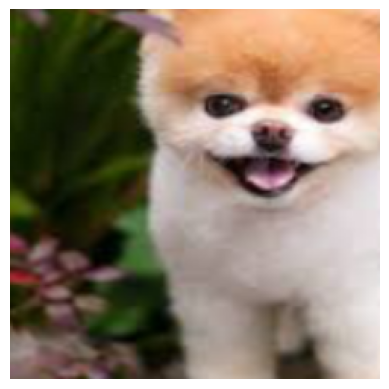

In [34]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os 
import torch.nn.functional as F

# 분류할 이미지 로드
image_path = r"C:\Users\bigdata\Dropbox\개인\Python\딥러닝\모델구현실습\cat_dog_classification\catanddog\actual/"  # 실제 이미지 경로
file_path = os.listdir(image_path)

image = Image.open(image_path + file_path[7]).convert("RGB")  # RGB 형식으로 변환
# display(image)

# 전처리 수행
input_tensor = transform(image).unsqueeze(0)  # 배치 차원을 추가

plt.imshow(np.transpose(transform(image), (1, 2, 0)))
plt.axis('off')


# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 모델로 예측 수행
input_tensor = input_tensor.to(device)
with torch.no_grad():
    output = model(input_tensor)
    
# 가장 높은 확률의 클래스 선택
probabilities = F.softmax(output, dim=1)

# 가장 높은 확률의 클래스 선택
max_prob, predicted_class = torch.max(probabilities, 1)  # 확률과 인덱스 반환


predicted_label = train_dataset.classes[predicted_class.item()]

print(f"Predicted Label: {predicted_label}, probabilities : {max_prob.item()*100:.2f}%")